<a href="https://colab.research.google.com/github/JamesBolt22/Supervised_Contrastive_learning_for_onset_detection/blob/main/VAE_mix_encoder_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
import tensorflow as tf
from tensorflow import keras
from keras import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
import pathlib
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
audio_path = "/content/drive/MyDrive/Data/Guitar_Audio/audio_hex-pickup_debleeded/"

songs= os.listdir(audio_path)
train_song_path = audio_path  + songs[0]

#y, sr = librosa.load(train_song_path, sr = 22050)


In [ ]:
new_data = []
j = 0
for song in songs:
    #print(song)
    train_song_path = audio_path  + song

    y, sr = librosa.load(train_song_path, sr = 22050)

    y = y/np.max(y)

    for i in range(math.floor((len(y)-11025)/11025)):
        temp = y[i*11025:(i*11025+11025)]
        print(np.mean(abs(temp)))
        new_data.append(temp/np.max(temp))

    j += 1
    print(j)



new_data = np.asarray(new_data)

new_data = np.reshape(new_data, (new_data.shape[0],new_data.shape[1],1))
print(new_data.shape)

Streaming output truncated to the last 5000 lines.
0.08015853
0.091019675
0.07480933
0.1017666
0.049865644
0.17663667
0.07253813
0.09693663
65
0.08597365
0.058509115
0.06679691
0.052468393
0.123489395
0.10951374
0.09153408
0.08484901
0.058430642
0.049681
0.080161996
0.10519434
0.12219503
0.12332937
0.07713199
0.037130687
0.10473938
0.08674872
0.0979135
0.08965222
0.09696479
0.07926323
0.07312586
0.066136055
0.015718753
0.08318757
0.08361311
0.102129966
0.088797756
0.051289227
0.06638933
0.07674741
0.07062666
0.06827449
0.04312071
0.07823844
0.08381209
0.06256635
0.1291558
0.07983458
0.07190502
0.10739784
0.08271139
66
0.021717219
0.11717948
0.09584957
0.14962867
0.059518877
0.07563018
0.035080224
0.02266169
0.0071109333
0.09384267
0.10578432
0.10611962
0.06356966
0.13569917
0.03996008
0.05137421
0.09853634
0.038172606
0.04005976
0.047442697
0.13997422
0.10855658
0.0694785
0.0531316
0.018852837
0.10556612
0.10930562
0.18135802
0.083944745
0.0019578962
0.06633383
0.16720288
0.202191
0.07

In [ ]:
def create_sin_array(num_sin_waves, start_f, end_f, fs, len):

  array = np.zeros(len)
  nx = np.linspace(0.0, len*1/fs, len, endpoint=False)
  ny = np.linspace(0.0, 1, num_sin_waves, endpoint=False)

  grid, not_grid =  np.meshgrid(nx, ny)

  frequencies = np.linspace(start_f, end_f, num_sin_waves)

  i = 0
  for freq_num in range(num_sin_waves):

    shift = np.random.randint(1000,10000)
    grid[freq_num] = np.roll(grid[freq_num], shift, axis=0)
    grid[freq_num] = grid[freq_num] * frequencies[freq_num]

    if i/num_sin_waves * 100 % 10 == 0:
      print(i/num_sin_waves * 100)
    i += 1

  array = np.sin(2 * np.pi * grid)

  print(array.shape)
  return array





In [ ]:
new_data = create_sin_array(10000,2000,3000, 22050, 5256)

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
(10000, 5256)


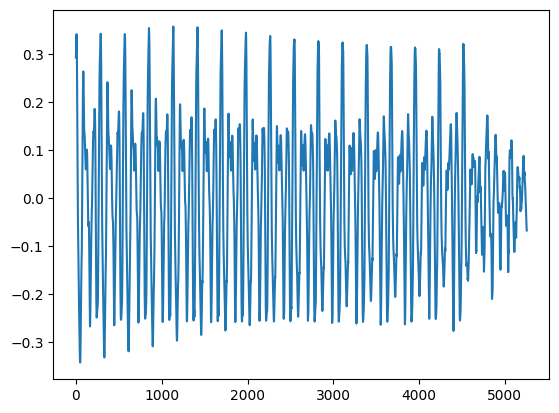

In [ ]:
plt.plot(new_data[0][0:5256])

In [6]:
np.random.seed(5)
np.random.shuffle(new_data)

sin_data = new_data#np.expand_dims(new_data, axis = 2)
av_data = ((sin_data- np.mean(sin_data))/np.std(sin_data))
print(np.mean(av_data))
print(np.std(av_data))

4.072953e-08
1.0000026


In [7]:
av_data.shape

(45468, 5256, 1)

In [8]:
av_data = np.reshape(av_data, (av_data.shape[0],av_data.shape[1],1))

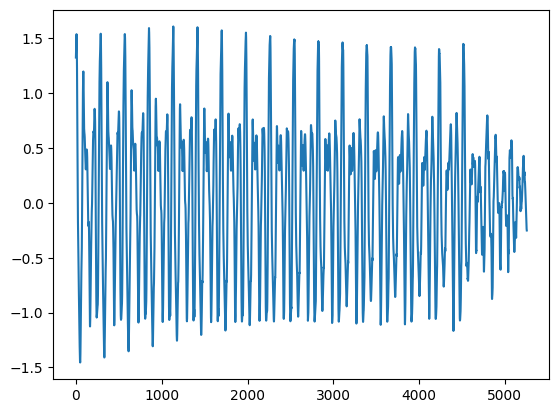

In [ ]:
plt.plot(av_data[0])

In [ ]:
print(np.max(av_data))

1.413914462296801


In [9]:
val_split = int(0.7*av_data.shape[0])
test_split = int(0.9*av_data.shape[0])

val_data = av_data[val_split:test_split]
val_label = sin_data[val_split:test_split]

test_data = av_data[test_split:]
test_label = sin_data[test_split:]

train_data = av_data[:val_split]
train_label = sin_data[:val_split]

val_comb  = (val_data,val_label)

In [10]:
def sinc(x):
    epsilon = 1e-15  # Small constant to avoid division by zero
    return tf.where(tf.abs(x) < epsilon, tf.ones_like(x), tf.sin(np.pi * x) / (np.pi * x))

In [11]:
def reparameterize(z_params):

  fs = 22050
  len = 256

  f1, wave = z_params
  f2 = f1 + 0.005
  f1 = f1 * fs/2
  f2 = f2 * fs/2

  f1 = tf.reduce_mean(f1, axis = 0)
  f2 = tf.reduce_mean(f2, axis = 0)

  n = tf.reshape(tf.linspace(-len/2, len/2, len), (1,len))
  nc = tf.reshape(tf.linspace(0, len, len)/len, (1,len))
  n = n * 1/fs
  n = tf.cast(n, "float32")
  f1 = tf.expand_dims(f1, 1)
  f2 = tf.expand_dims(f2, 1)

  b = tf.constant([128,1], tf.int32)
  c = tf.constant([1,len], tf.int32)
  n = tf.tile(n, b)

  f2 = tf.tile(f2, c)
  f1 = tf.tile(f1, c)

  f1n = tf.math.multiply(n,f1)
  f2n = tf.math.multiply(n,f2)
  sinc_filter = 2*f2*sinc(f2n) - 2*f1*sinc(f1n)
  cos_filter = tf.cast((0.42 - 0.5 * tf.math.cos(2 * math.pi * nc) + 0.08 * tf.math.cos(4 * math.pi * nc)), "float32")

  windowed_filter = sinc_filter * cos_filter

  windowed_filter = tf.transpose(windowed_filter)
  windowed_filter = tf.reshape(windowed_filter, (len, 1, 128))
  output = tf.nn.conv1d(wave, windowed_filter, stride = 1, padding = 'SAME' ,data_format = "NWC")

  #output = output/tf.reduce_max(output, axis = 1)

  return output

In [12]:
def build_encoder():

  input = tf.keras.Input(shape=(5256,1))
  x = layers.BatchNormalization()(input)
  x = layers.Conv1D(128, 10, activation='relu', strides=5)(x)
  flatten = layers.GlobalAveragePooling1D()(x)
  f1 = layers.Dense(128, activation  = 'sigmoid')(flatten)
  #f2 = layers.Dense(128, activation  = 'sigmoid')(flatten)

  #features = layers.Lambda(reparameterize)([f1,f2,input])
  features = layers.Lambda(reparameterize)([f1,input])
  embeddings = layers.BatchNormalization()(features)
  x = layers.Conv1D(128, 12, activation='relu', strides=4)(embeddings)
  x = layers.Conv1D(128, 4, activation='relu', strides=4)(x)

  return tf.keras.Model(inputs=input, outputs = x)


In [13]:
encoder = build_encoder()
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5256, 1)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 5256, 1)     4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv1d (Conv1D)                (None, 1050, 128)    1408        ['batch_normalization[0][0]']    
                                                                                                  
 global_average_pooling1d (Glob  (None, 128)         0           ['conv1d[0][0]']             

In [14]:
def build_decoder(encoder):

  input = tf.keras.Input(shape=(5256,1))
  features= encoder(input)
  x  = layers.Conv1DTranspose(128, kernel_size=4, strides=4, activation='relu')(features)
  x  = layers.Conv1DTranspose(128, kernel_size=12, strides=4, activation='relu')(x)
  output = layers.Conv1D(1, kernel_size=1, activation='tanh', name='waveoutput')(x)
  #diff = layers.Dense(1,name='diff')(diff)

  return tf.keras.Model(inputs=input, outputs = output)


In [15]:
decoder = build_decoder(encoder)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5256, 1)]         0         
                                                                 
 model (Functional)          (None, 328, 128)          280836    
                                                                 
 conv1d_transpose (Conv1DTra  (None, 1312, 128)        65664     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 5256, 128)        196736    
 ranspose)                                                       
                                                                 
 waveoutput (Conv1D)         (None, 5256, 1)           129       
                                                                 
Total params: 543,365
Trainable params: 543,107
Non-trainab

In [16]:
decoder.compile(optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=0.05), loss= mean_absolute_error)

In [17]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5256, 1)]         0         
                                                                 
 model (Functional)          (None, 328, 128)          280836    
                                                                 
 conv1d_transpose (Conv1DTra  (None, 1312, 128)        65664     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 5256, 128)        196736    
 ranspose)                                                       
                                                                 
 waveoutput (Conv1D)         (None, 5256, 1)           129       
                                                                 
Total params: 543,365
Trainable params: 543,107
Non-trainab

In [18]:
checkpoint_filepath = '/content/drive/MyDrive/PhD/Frontend/Checkpoints/guitar/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
history = decoder.fit(x = train_data, y= train_label, validation_data = val_comb, epochs=400,
                shuffle=True, batch_size =256, callbacks = [model_checkpoint_callback])

Epoch 1/400
125/125 [==============================] - 88s 677ms/step - loss: 0.2644 - val_loss: 0.2607
Epoch 2/400
125/125 [==============================] - 84s 675ms/step - loss: 0.2634 - val_loss: 0.2607
Epoch 3/400
125/125 [==============================] - 81s 650ms/step - loss: 0.2631 - val_loss: 0.2606
Epoch 4/400
125/125 [==============================] - 81s 648ms/step - loss: 0.2630 - val_loss: 0.2606
Epoch 5/400
125/125 [==============================] - 84s 674ms/step - loss: 0.2630 - val_loss: 0.2606
Epoch 6/400
125/125 [==============================] - 81s 650ms/step - loss: 0.2628 - val_loss: 0.2605
Epoch 7/400
125/125 [==============================] - 84s 671ms/step - loss: 0.2628 - val_loss: 0.2605
Epoch 8/400
125/125 [==============================] - 84s 674ms/step - loss: 0.2626 - val_loss: 0.2605
Epoch 9/400
125/125 [==============================] - 81s 650ms/step - loss: 0.2626 - val_loss: 0.2603
Epoch 10/400
125/125 [==============================] - 84s 671m

In [19]:
decoder.load_weights(checkpoint_filepath)

In [ ]:
decoder.save('/content/drive/MyDrive/PhD/Frontend/Models/sine_test_2k_3k_conv')

In [20]:
audio = decoder.predict(val_data)

285/285 [==============================] - 17s 24ms/step


In [21]:
reconstruction = np.array([[0]])

for i in audio:

    reconstruction = np.concatenate([reconstruction,i])

In [ ]:
import soundfile as sf

In [ ]:
sf.write('new_file4.wav', reconstruction[0:220500], 22050)

In [ ]:
  from IPython.display import Audio

  Audio('new_file4.wav', autoplay=True)

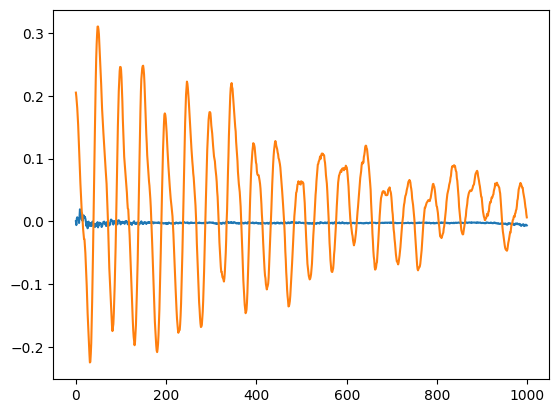

In [22]:
plt.plot(reconstruction[0:1000])
plt.plot(val_data[0][0:1000])

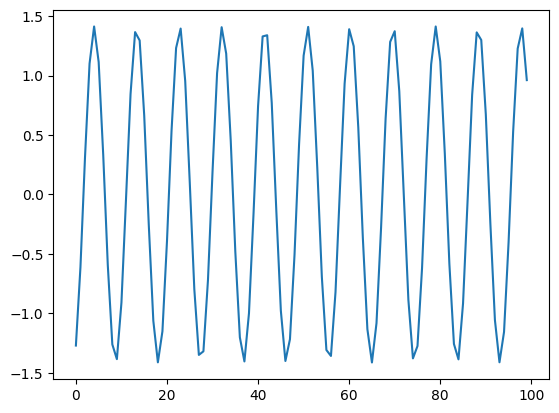

In [ ]:
plt.plot(val_data[0][0:100])

In [ ]:
sf.write('test_file.wav', test_data, 22050)

In [23]:
feature_space = encoder.predict(val_data[0:2])

1/1 [==============================] - 0s 360ms/step


In [28]:
intermediate_layer_model_1 = Model(inputs=encoder.input,
                                 outputs=encoder.layers[4].output)
intermediate_output_1 = intermediate_layer_model_1.predict(val_data)

285/285 [==============================] - 1s 2ms/step


In [29]:
intermediate_layer_model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5256, 1)]         0         
                                                                 
 batch_normalization (BatchN  (None, 5256, 1)          4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 1050, 128)         1408      
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
Total params: 17,924
Trainable params: 17,922
Non-trainable

In [30]:
x = []

for i in intermediate_output_1:

    x.append(i)


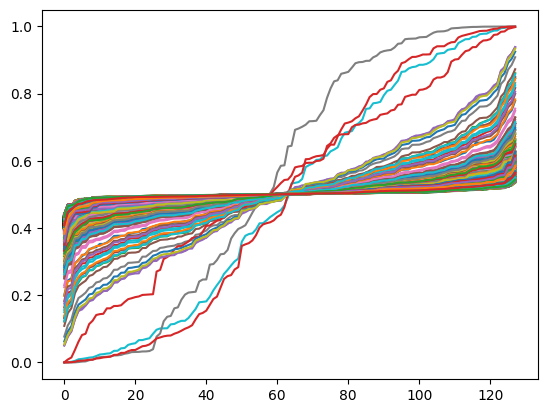

In [31]:
for j in x:
  plt.plot(sorted(j))

In [ ]:
low_freq_mel = 80
high_freq_mel = (2595 * np.log10(1 + 3000 / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, 128)  # Equally spaced in Mel scale
f_cos = (700 * (10 ** (mel_points / 2595) - 1))  # Convert Mel to Hz
print(f_cos)

[  51.4957977    60.98753306   70.59915338   80.33217285   90.18812481
  100.16856194  110.27505656  120.50920082  130.872607    141.36690774
  151.99375629  162.75482679  173.65181454  184.68643621  195.86043021
  207.17555685  218.63359872  230.23636089  241.98567124  253.88338076
  265.93136379  278.13151835  290.48576643  302.99605432  315.66435285
  328.49265779  341.48299008  354.63739621  367.95794849  381.44674544
  395.10591206  408.9376002   422.94398887  437.12728464  451.48972192
  466.03356334  480.76110012  495.67465243  510.77656972  526.06923112
  541.55504582  557.23645345  573.11592441  589.19596036  605.4790945
  621.96789207  638.66495069  655.57290079  672.69440603  690.0321637
  707.58890518  725.36739632  743.37043793  761.60086619  780.06155309
  798.75540689  817.68537262  836.85443246  856.26560629  875.92195211
  895.82656657  915.9825854   936.39318396  957.06157771  977.99102272
  999.18481618 1020.64629694 1042.37884601 1064.38588711 1086.67088719
 1109.23

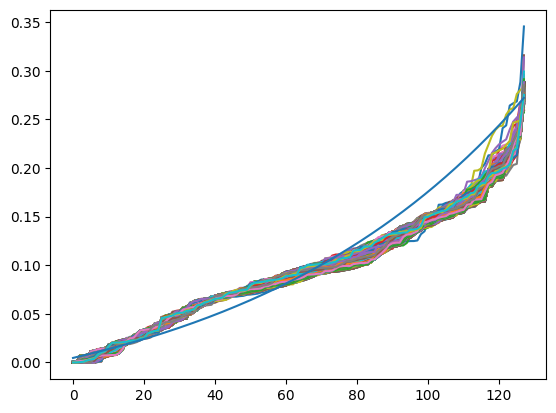

In [ ]:
for j in x:
  plt.plot(sorted(j))

plt.plot(f_cos/11025)

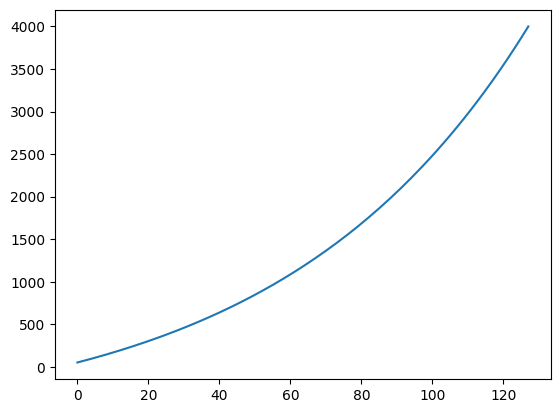

In [ ]:
plt.plot(f_cos)

In [ ]:
print(x[0])

[4.20983396e-02 5.91259524e-02 8.81132111e-03 6.37496263e-02
 2.44146567e-02 3.63551304e-02 1.99608877e-02 7.52899941e-05
 6.33073151e-02 2.90497001e-02 4.14000731e-03 4.24672589e-02
 1.43970856e-02 9.06718429e-03 4.80589308e-02 6.33389279e-02
 6.50790855e-02 3.38671580e-02 1.06283829e-01 9.28718150e-02
 2.17286870e-02 4.86461371e-02 1.27326725e-02 5.02963290e-02
 6.11444823e-02 4.53445353e-02 5.14287129e-02 4.70817462e-02
 1.92420203e-02 2.85045765e-02 3.33472301e-04 7.06321970e-02
 5.04493937e-02 7.13396147e-02 1.02333151e-01 5.22082113e-02
 4.75194585e-03 2.52063014e-02 5.58159165e-02 9.21785925e-03
 3.93693112e-02 6.41721394e-03 3.62790488e-02 5.57210632e-02
 5.57008497e-02 1.83771718e-02 7.42633769e-04 2.31424114e-03
 3.31640579e-02 3.52330394e-02 5.79637336e-03 5.14711142e-02
 3.07822209e-02 5.00125848e-02 7.69778043e-02 4.10246477e-02
 2.81888843e-02 5.22810444e-02 3.60137224e-02 7.67830387e-02
 7.47398660e-02 2.78046932e-02 5.29137328e-02 1.72230916e-03
 4.30888496e-02 1.678121

In [ ]:
def create_sinc_filters(f1):

  fs = 22050
  len = 256

  f1 = f1
  f2 = f1 + 0.0005
  f1 = f1 * fs/2
  f2 = f2 * fs/2
  print(f1[0])
  print(f2[])
  f1 = tf.reduce_mean(f1, axis = 0)
  f2 = tf.reduce_mean(f2, axis = 0)

  n = tf.reshape(tf.linspace(-len/2, len/2, len), (1,len))
  n = n * 2 * 1/fs
  n = tf.cast(n, "float32")
  f1 = tf.expand_dims(f1, 1)
  f2 = tf.expand_dims(f2, 1)

  b = tf.constant([128,1], tf.int32)
  c = tf.constant([1,len], tf.int32)
  n = tf.tile(n, b)

  f2 = tf.tile(f2, c)
  f1 = tf.tile(f1, c)

  f1n = tf.math.multiply(n,f1)
  f2n = tf.math.multiply(n,f2)
  sinc_filter = 2*f2*tf.experimental.numpy.sinc(f2n) - 2*f1*tf.experimental.numpy.sinc(f1n)
 
  return sinc_filter

In [ ]:
freqs = np.reshape(x[0], (x[0].shape[0], 1))
sinc_filters = create_sinc_filters(freqs)

[464.1342]
[469.6467]


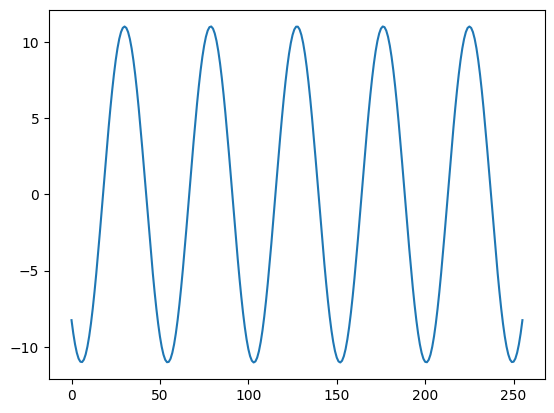

In [ ]:
plt.plot(sinc_filters[10])

In [ ]:
from scipy.fft import fft, fftfreq

In [ ]:
def fft_plot(array, fs, len):

  yf = fft(array)
  xf = fftfreq(len, 1/fs)[:len//2]

  plt.plot(xf, 2.0/len * np.abs(yf[0:len//2]))
  plt.grid()
  plt.show()


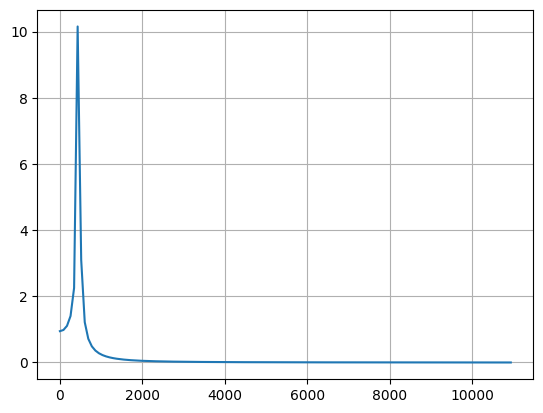

In [ ]:
fft_plot(sinc_filters[0].numpy(), 22050, 256)